# Programming Task

Find the optimal learning rate of a simple ResNet on FashionMNIST. 

## Installation

Clone the GitHub repository `minimal-bayesopt` and install its dependencies.


In [2]:
!git clone git@github.com:stwerner97/minimal-bayesopt.git
%cd /content/minimal-bayesopt
!pip install -r requirements.txt

fatal: destination path 'minimal-bayesopt' already exists and is not an empty directory.
/content/minimal-bayesopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 27.3 MB/s 
     |████████████████████████████████| 1.4 MB 68.7 MB/s 
     |████████████████████████████████| 96 kB 6.1 MB/s 
     |████████████████████████████████| 4.7 MB 61.0 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 944 kB 56.9 MB/s 
     |████████████████████████████████| 144 kB 67.7 MB/s 
     |████████████████████████████████| 140 kB 76.3 MB/s 
     |████████████████████████████████| 167 kB 74.3 MB/s 
     |████████████████████████████████| 4.5 MB 44.6 MB/s 
     |████████████████████████████████| 61 kB 8.0 MB/s 
     |████████████████████████████████| 11.2 MB 52.2 MB/s 
     |████████████████████████████████| 94 kB 4.9 MB/s 
ERROR: Could not find a version that sa

## Building the ResNet Architecture
The ResNet uses residual blocks as in the [original paper](https://arxiv.org/pdf/1512.03385.pdf), but also uses skip connections inspired by the [NVAE paper](https://arxiv.org/pdf/2007.03898.pdf).

In [29]:
from typing import Union, Tuple, Dict

import torch
import pytorch_lightning as pl
from torch import nn
from torch import Tensor
from torch.optim import Optimizer, SGD
from torchmetrics import F1Score


class ConvBlock(nn.Module):
    """Basic Conv. Neural Network building block."""
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int]],
        stride: Union[int, Tuple[int]],
        padding: Union[int, Tuple[int]],
        padding_mode: str = "zeros",
        bias: bool = False,
        activation: nn.Module = nn.SiLU,
        norm_layer: nn.Module = nn.BatchNorm2d,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            padding_mode=padding_mode,
            bias=bias,
        )

        self.norm_layer = norm_layer
        if self.norm_layer is not None:
            self.norm_layer = self.norm_layer(out_channels)

        self.activation = activation
        if self.activation is not None:
            self.activation = activation()

    def forward(self, x: Tensor) -> Tensor:
        """Apply conv. filters, normalization and activation function."""
        out = self.conv(x)
        if self.norm_layer is not None:
            out = self.norm_layer(out)

        if self.activation is not None:
            out = self.activation(out)

        return out


class ResNetBlock(nn.Module):
    """Residual learning building block.

    Residual learning building block stacking two conv. blocks. Downsampling
    is applied at the first conv. block (if stride > 1). Similarly, the
    number of channels is expanded / reduced at the first conv. block.
    The skip connection is inspired by https://arxiv.org/pdf/2007.03898.pdf.
    It downsamples the input using 1x1 convolutions.

    Parameters
    ----------
    in_channels : int
        Number of channels of the input tensor.
    out_channels : int
        Number of channels of the output tensor. The number of channels is
        expanded / reduced at the first conv. layer.
    stride : int
        Downsampling performed in the first conv. layer.
    activation : nn.Module
        Nonlinear activation function. Activations are applied within the
        first conv. block and after the skip connection and main branch
        are accumulated.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int,
        activation: nn.Module = nn.SiLU,
        norm_layer: nn.Module = nn.BatchNorm2d,
    ):
        super().__init__()

        self.convblock1 = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            activation=activation,
            norm_layer=norm_layer,
        )

        self.convblock2 = ConvBlock(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            activation=None,
            norm_layer=norm_layer,
        )

        self.skipblock = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=0,
            activation=None,
            norm_layer=norm_layer,
        )

        self.activation = activation()

    def forward(self, x: Tensor) -> Tensor:
        """Passes input tenor thorugh residual block."""
        skip = self.skipblock(x)
        out = self.convblock1(x)
        out = self.convblock2(out)
        out = self.activation(out + skip)

        return out

The ResNet stacks four residual blocks after an initial convolution and pooling layer. Similar to the [original paper](https://arxiv.org/pdf/1512.03385.pdf), we use global average pooling before the fully connected output layer and do not use dropouts or any other means to regularize the network.

In [30]:
class ResNetModel(nn.Module):
    """ResNet neural network architecture for FashionMNIST.

    The architecture is a lightweight version of the ResNet proposed
    in https://arxiv.org/pdf/1512.03385.pdf. As in the paper, the architecture
    does not use strong regularization such as dropout or maxout. After an
    initial conv. layer and pooling stage, the architecture stacks ResNet
    blocks. Finally, logits for each class are computed using global average
    pooling and a fully connected layer.

    Parameters
    ----------
    num_classes : int
        Number of possible class labels in the classification task.
    activation : nn.Module
        Activation function to use throughout the architecture.
    norm_layer : nn.Module
        Normalization layer to use throughout the architecture.
    """

    def __init__(
        self,
        num_classes: int = 10,
        activation: nn.Module = nn.SiLU,
        norm_layer: nn.Module = nn.BatchNorm2d,
    ):
        super().__init__()

        self.conv5x5block_l1 = ConvBlock(
            in_channels=1,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2,
            activation=activation,
            norm_layer=norm_layer,
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.resblock_l2 = ResNetBlock(
            in_channels=32,
            out_channels=32,
            stride=2,
            activation=activation,
            norm_layer=norm_layer,
        )

        self.resblock_l3 = ResNetBlock(
            in_channels=32,
            out_channels=32,
            stride=1,
            activation=activation,
            norm_layer=norm_layer,
        )

        self.resblock_l4 = ResNetBlock(
            in_channels=32,
            out_channels=64,
            stride=2,
            activation=activation,
            norm_layer=norm_layer,
        )

        self.resblock_l5 = ResNetBlock(
            in_channels=64,
            out_channels=64,
            stride=1,
            activation=activation,
            norm_layer=norm_layer,
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fclayer = nn.Linear(64, num_classes)

    def forward(self, images: Tensor) -> Tensor:
        """Maps FashionMNIST images to logits for each class.

        Parameters
        ----------
        images : Tensor (Batch size, Channels, Height, Width)
            Batch of FashionMNIST images.

        Returns
        -------
        Tensor (Batch size, Num. Classes)
            Raw, unnormalized logit scores for each class.
        """
        out = self.conv5x5block_l1(images)
        out = self.maxpool(out)

        out = self.resblock_l2(out)
        out = self.resblock_l3(out)

        out = self.resblock_l4(out)
        out = self.resblock_l5(out)

        out = self.avgpool(out)

        out = torch.flatten(out, start_dim=1)
        out = self.fclayer(out)

        return out

## Training Module

We use `pytorch-lightning` as a lightweight and modular training framework. During the training stage, we minimize the cross-entropy loss as an auxiliary to the F1 score that is used as a validation metric.

In [31]:
class ResNetFashionMnistModule(pl.LightningModule):
    """Training module for the FashionMNIST classification task.

    During training, minimizes the cross-entropy among predicted and
    ground-truth labels as an auxiliary to the F1 metric (used during
    validation & testing). Optimizes the NN with a SGD optimizer.

    Parameters
    ----------
    model : nn.Module
        Neural network that maps input images to logits for each class label.
    num_classes : int
        Number of classes of the classification task.
    lr : float
        Learning rate of the SGD optimizer.
    """

    def __init__(self, model: nn.Module, num_classes: int, lr: float = 1e-3):
        super().__init__()

        self.model = model
        self.lr = lr

        self.loss = nn.CrossEntropyLoss()
        self.f1 = F1Score(num_classes=num_classes)

    def forward(self, *args, **kwargs):
        """Wraps the forward pass of the inner model."""
        return self.model(*args, **kwargs)

    def training_step(self, batch: Tuple[Tensor], batch_idx: int) -> Dict:
        """Computes the cross-entropy between predicted and ground-truth labels.

        Parameters
        ----------
        batch : Tuple[Tensor]
            Batch of FashionMNIST images and their target labels.
        batch_idx : int
            Index of batch in training data loader.

        Returns
        -------
        Dict
            Cross-entropy training loss.
        """
        images, targets = batch

        logits = self(images)
        loss = self.loss(logits, targets)
        self.log("train_cross_entropy", loss)

        return {"loss": loss}

    def validation_step(self, batch: Tuple[Tensor], batch_idx: int) -> Dict:
        """Computes the predicted class labels.

        Parameters
        ----------
        batch : Tuple[Tensor]
            Batch of FashionMNIST images and their target labels.
        batch_idx : int
            Index of batch in training data loader.

        Returns
        -------
        Dict
            Predicted and ground-truth labels of the images.
        """
        images, targets = batch

        logits = self(images)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        return {"Targets": targets, "Preds.": preds}

    def validation_epoch_end(self, outputs: Dict) -> Dict:
        """Compares predicted and ground-truth class labels in terms of the F1 score.

        Parameters
        ----------
        batch : Tuple[Tensor]
            Batch of FashionMNIST images and their target labels.
        batch_idx : int
            Index of batch in training data loader.

        Returns
        -------
        Tensor
            Dict that stores the F1 score of validation stage.
        """

        targets = torch.cat([output["Targets"] for output in outputs])
        preds = torch.cat([output["Preds."] for output in outputs])

        f1_score = self.f1(preds, targets)
        self.log("val_f1_score", f1_score)

        return f1_score

    def configure_optimizers(self) -> Optimizer:
        """Set up SGD optimizer."""
        return SGD(self.parameters(), lr=self.lr)


## Defining the Objective Function
The `optimize` function first prepares the FashionMNIST data, splits it into training and validation data before running the training loop. The ResNet is trained for at most `max_epochs`, although the early stopping callback may terminate the optimization sooner. The `optimize` function reports back the final F1 score on the validation data.

In [32]:
import logging
import warnings
from argparse import Namespace
from functools import partial

import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
import ConfigSpace.hyperparameters as CSH
from torch import Generator
from torchvision import transforms
from sklearn.gaussian_process.kernels import Matern
from matplotlib.backends.backend_pdf import PdfPages


def optimize(
    val_size: float = 0.3,
    max_epochs: int = 10,
    batch_size: int = 128,
    patience: int = 0,
    lr: float = 1e-3,
    generator: Generator = None,
) -> float:
    """Trains and evaluates a ResNet on the FashionMNIST classification task.

    Splits the training data into training and validation sets. Trains the ResNet until the early
    stopping criterion is met or the maximum number of epochs is reached. Reports the validation
    performance in terms of its F1 score.

    Parameters
    ----------
    val_size : float
        Fraction of the number of training samples used as validation data.
    max_epochs : int
        Number of epochs the neural network is trained at most.
    batch_size : int
        Batch size of training & validation data loaders.
    patience : int
        Maximum number of validation checks with no improvement before the training is stopped early.
    lr : float
        Learning rate of the SGD optimizer.
    generator: Generator
        Random number generator used to train / test split.

    Returns
    -------
    float
        Final F1 score of the ResNet on the validation data.
    """

    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore")

    transform = transforms.ToTensor()
    data = torchvision.datasets.FashionMNIST(
        "fashion-mnist", download=True, train=True, transform=transform
    )

    train = int(np.floor((1.0 - val_size) * len(data)))
    val = int(np.ceil(val_size * len(data)))
    train, val = torch.utils.data.random_split(data, (train, val), generator=generator)

    train = torch.utils.data.DataLoader(train, batch_size=batch_size)
    val = torch.utils.data.DataLoader(val, batch_size=batch_size)

    model = ResNetModel(num_classes=10)
    module = ResNetFashionMnistModule(model, num_classes=10, lr=lr)

    early_stopping = pl.callbacks.EarlyStopping(
        monitor="val_f1_score", mode="max", patience=patience
    )

    trainer = pl.Trainer(
        gpus=torch.cuda.device_count(),
        max_epochs=max_epochs,
        callbacks=[early_stopping],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=None,
    )
    trainer.validate(module, val, verbose=False)
    trainer.fit(module, train, val)

    f1_score = trainer.logged_metrics["val_f1_score"].item()
    return f1_score

## Bayesian Optimization

The `BayesOpt` class implements the Bayesian Optimization algorithm. The `search` method uses `scipy.optimize` to find a parameter in the search space that maximizes the acquisition function (here: expected improvement). In contrast to the objective function, it is cheap to evaluate when using a Gaussian Process as a probabilistic surrogate. After evaluating the sample in terms of the objective function, the `update` method is called to re-train the surrogte given the newly acquired data.

In [33]:
import sys
import logging
from functools import partial
from typing import Callable, Dict, Tuple

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ConfigSpace.hyperparameters as CSH
from scipy.stats import norm
from scipy.optimize import minimize, Bounds
from sklearn.gaussian_process import GaussianProcessRegressor


class BayesOpt:
    """Bayesian Optimization algorithm.

    Implements a Bayesian Optimization algorithm that maximizes the value of an objective function w.r.t. a parameter of the search space.

    Parameters
    ----------
    space : CSH.FloatHyperparameter
        Search space of the parameter to optimize.
    objective : Callable (m,) -> (1)
        The objective function to maximize with Bayesian Optimization. Expects a function that maps a 1-D array (the parameter) to a scalar value (the objective value).
    acquisition : Dict
        Dictionary that specifies the acquisition function to use (key: `acquisition`) and other parameters.
    minimizer_kwargs : Dict
        Specifies the configuration of the optimizer used to maximize the acquisition function. The parameters are passed to `scipy.optimize`.
    surrogate : Dict
        Specifies the configuration of the Gaussian Process Regressor. Its parameters are passed to the constructor of the surrogate.
    log_freq : int
        Specifies the frequency at which `BayesOpt` renders the landscape of the surrogate and acquisition function.
    seed : int
        The seed of the pseudo random number generator to use.

    Attributes
    ----------
    surrogate : GaussianProcessRegressor
        Probabilistic surrogate of the objective function's landscape.
    xsamples : np.ndarray
        Samples of the search space where the objective function was evaluated.
    ysamples : np.ndarray
        Objective value of the search space samples in `xsamples`.
    """

    EPS = 1e-8

    def __init__(
        self,
        space: CSH.FloatHyperparameter,
        objective: Callable,
        acquisition: Dict = None,
        minimizer_kwargs: Dict = None,
        surrogate: Dict = None,
        log_freq: int = None,
        seed: int = None,
    ):
        np.random.seed(seed)

        self.space = space
        self.objective = objective
        self.log_freq = log_freq
        self.seed = seed

        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s [%(levelname)s] %(message)s",
            handlers=[logging.StreamHandler(sys.stdout)],
        )

        if acquisition is None:
            acquisition = {"acquisition": "expected_improvement", "xi": 0.01}

        # Pass static parameters such as `xi` to the acquisition function.
        # Now, the function expects only samples of the search space as an input.
        self.acquisition = getattr(self, acquisition.pop("acquisition"))
        self.acquisition = partial(self.acquisition, **acquisition)

        if surrogate is None:
            surrogate = {}

        if minimizer_kwargs is None:
            minimizer_kwargs = {"method": "L-BFGS-B", "nrestarts": 25}

        self.minimizer_kwargs = minimizer_kwargs

        # Standardizes target values, to mitigate problems posed by
        # ill-conditioned covariance matrices.
        self.surrogate = GaussianProcessRegressor(
            random_state=self.seed, normalize_y=True, **surrogate
        )

        self.xsamples = np.empty((0, 1), dtype=np.float32)
        self.ysamples = np.empty((0, 1), dtype=np.float32)

    def optimize(self, niters: int) -> Tuple[float]:
        """Run the Bayesian Optimization loop.

        Iteratively search the surrogate landscape for a sample of the search space maximizing the acquisition function, evaluate its objective value and refit the surrogate.

        Parameters
        ----------
        niters : int
            The number of iterations of the Bayesian Optimization loop. Overall, the objective value is evaluated `niter` times.

        Returns
        -------
        Tuple (float, float)
            The parameter that maximized the objective function during the search and its objective value.
        """
        for _ in range(niters):
            xsample = self.search()
            ysample = self.objective(**{self.space.name: xsample})

            xsample = np.asarray(xsample, dtype=np.float32).reshape(1, -1)
            ysample = np.asarray(ysample, dtype=np.float32).reshape(1, -1)

            self.update(xsample, ysample)

            if self.log_freq is not None and self.num_xsamples % self.log_freq == 0:
                logging.info(
                    f"Num Evals. {self.num_xsamples}; Max. Obj. Value: {self.yopt:.5f}; Best Sample.: {self.xopt:.5f}"
                )
                self.render()

        return self.xopt, self.yopt

    def search(self, nrestarts: int = 25, minimizer_kwargs: Dict = {}) -> float:
        """Search for a maximizer of the acquisition function.

        Search the surrogate landscape for a point that maximizes the acquisition function using `scipy.optimize`.

        Parameters
        ----------
        nrestarts : int
            The number of restarts of the L-BFGS-B optimization algorithm.
        minimizer_kwargs : Dict
            Parameters passed to `scipy.optimize`.

        Returns
        -------
        float
            The sample whose acquisition function value was maximum during the search.
        """
        if self.num_xsamples <= 0:
            return self.space.rvs()

        # Define an auxiliary function as the negative acquisition function,
        # since SciPy expects a minimization rather than a maximization problem.
        def auxiliary(xsample):
            return -1.0 * self.acquisition(xsamples=xsample.reshape(1, -1))

        bounds = Bounds(self.space.lower, self.space.upper)

        minimizer = None

        # Local optimization algorithms (e.g. L-BFGS-B) are sensitive to their starting conditions.
        # Use `nrestarts` random samples of the search space as starting points
        # to the optimization.
        for _ in range(nrestarts):
            x0 = np.random.uniform(self.space.lower, self.space.upper, size=(1,))
            result = minimize(auxiliary, x0=x0, bounds=bounds, **minimizer_kwargs)

            minimizer = result if minimizer is None else minimizer
            minimizer = result if result.fun < minimizer.fun else minimizer

        return float(minimizer.x)

    def update(self, xsample: np.ndarray, ysample: np.ndarray) -> None:
        """Update the surrogate given a sample and its objective value.

        Refits the Gaussian Process Regressor given the a sample and its objective value.

        Parameters
        ----------
        xsample : np.ndarray (m, 1)
            Samples of the search space.
        ysample : np.ndarray (m, 1)
            Objective values of the samples.
        """
        self.xsamples = np.vstack((self.xsamples, xsample))
        self.ysamples = np.vstack((self.ysamples, ysample))

        self.surrogate.fit(self.xsamples, self.ysamples)

    def expected_improvement(
        self, xsamples: np.ndarray, xi: float = 0.01
    ) -> np.ndarray:
        """Compute the Expected Improvement (EI) at the passed sampling points.

        Evaluates the EI at sampling points `xsamples` under the probabilistic surrogate model. EI trades-off the predicted probability of improvement and the extent to which the objective value is expected to increase.

        Parameters
        ----------
        xsamples : np.ndarray (m, n)
            Sample points at which the EI acquisition function is computed.
        xi : float
            An exploration parameter. The Bayesian Optimization samples points of higher uncertainty (standard deviation) as `xi` increases.

        Returns
        -------
        np.ndarray (m, 1)
            EI scores evaluated at sampling points `xsamples`.
        """

        mean, std = self.surrogate.predict(xsamples, return_std=True)
        mean, std = mean.reshape(-1), std.reshape(-1)

        impr = mean - self.yopt - xi
        Z = impr / (std + self.EPS)
        eximpr = impr * norm.cdf(Z) + std * norm.pdf(Z)

        return eximpr

    def render(self, n_samples: int = 200) -> plt.Figure:
        """Shows the surrogate and acquisition function landscape.

        Parameters
        ----------
        n_samples : int
            Number of functions samples from the Gaussian Process Regressor.

        Returns
        -------
        plt.Figure
            Figure that plots the surrogate and acquisition function landscape.
        """

        sns.set_style("whitegrid")
        plt.rcParams.update({"font.size": 14})

        fig, axes = plt.subplots(
            nrows=2,
            figsize=(10, 4),
            gridspec_kw={"height_ratios": [3, 1]},
            sharex=True,
        )

        axes[0].set_xlim(self.space.lower, self.space.upper)
        axes[0].set_ylabel("Obj. Value")
        axes[1].set_xlim(self.space.lower, self.space.upper)
        axes[1].set_xlabel(self.space.name)
        axes[1].set_ylabel("Acq. Func.")

        # Sample & plot functions defined over the search space from the Gaussian Process Regressor.
        xsamples = np.linspace(self.space.lower, self.space.upper, 1000).reshape(-1, 1)
        mean, std = self.surrogate.predict(xsamples, return_std=True)
        mean, std = mean.reshape(-1), std.reshape(-1)
        ysamples = self.surrogate.sample_y(xsamples, n_samples=n_samples)
        ysamples = np.squeeze(ysamples)

        for ysample in ysamples.T:
            axes[0].plot(xsamples, ysample, alpha=0.05, color="tab:gray")

        # Plot posterior mean & uncertainty estimates.
        axes[0].plot(xsamples, mean, alpha=0.8, color="black")
        axes[0].fill_between(xsamples.reshape(-1), mean + std, mean - std, alpha=0.4, color="darkorange")

        # Plot the search space samples & objective values of prior evaluations.
        xsampels = self.xsamples.reshape(-1)
        ysamples = self.ysamples.reshape(-1)
        axes[0].scatter(xsampels, ysamples, s=40, color="black", zorder=2.5)
        
        # Plot marker for best sample found so far.
        axes[0].scatter(self.xopt, self.yopt, s=100, color="maroon", zorder=2.5, marker="X")

        # Plot the acquisition function landscape.
        xsamples = np.linspace(self.space.lower, self.space.upper, 1000).reshape(-1, 1)
        eximpr = self.acquisition(xsamples=xsamples)
        xsamples, eximpr = xsamples.reshape(-1), eximpr.reshape(-1)
        axes[1].plot(xsamples, eximpr, color="tab:blue")
        axes[1].fill_between(xsamples, eximpr, alpha=0.4, color="tab:blue")


        sns.despine()
        plt.tight_layout()
        return fig

    @property
    def yopt(self) -> float:
        """float: Objective value of the best search space sample."""
        yopt = np.max(self.ysamples, axis=0)
        return float(yopt)

    @property
    def xopt(self) -> float:
        """float: Parameter of the search space with max. objective value."""
        xopt = self.xsamples[np.argmax(self.ysamples, axis=0)]
        return float(xopt)

    @property
    def num_xsamples(self) -> int:
        """int: Number of evaluated samples."""
        return len(self.xsamples)


## Run the Optimization Loop

First, we define the search space of the learning rate parameter over a log-scale. Then, the optimization is run for 10 steps. At each step, we plot the samples, uncertainty estimate and acquisition function landscape. For the purpose of this demo, the `max_epoch` parameter is set to a low number.

In [41]:
from sklearn.gaussian_process.kernels import Matern


# Define search space of LR over log scale.
lr = CSH.UniformFloatHyperparameter(
    "lr", lower=1e-5, upper=1e-1, log=True
)

# Define parameters of acquisition function, minimization and surrogate.
acquisition = {"acquisition": "expected_improvement", "xi": 0.01}
minimizer_kwargs = {"method": "L-BFGS-B", "nrestarts": 25}
kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
surrogate = {"n_restarts_optimizer": 10, "kernel": kernel}

# Random number generator used to train / test split.
generator = Generator()
generator.manual_seed(0)

# Define parameters of evaluation function except for learning rate.
objective = {
    "val_size": 0.3,
    "max_epochs": 20,
    "batch_size": 128,
    "patience": 0,
    "generator": generator,
}
objective = partial(optimize, **objective)

bayesopt = BayesOpt(
    space=lr,
    objective=objective,
    acquisition=acquisition,
    minimizer_kwargs=minimizer_kwargs,
    surrogate=surrogate,
    log_freq=1,
    seed=0,
)

Each plot shows the points sampled so far and their objective value (markers). The cross highlights the best parameter found so far. The black line shows the surrogate's posterior mean, while the orange area around its quantifies the uncertainty estimates (i.e. mean ± std). Additionally, we show functions samples from the posterior in grey.

Below, we plot acquisition function (here: expected improvement) over the search space.

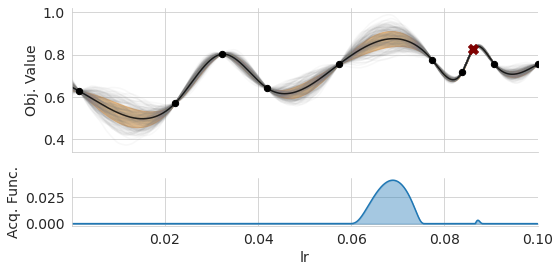

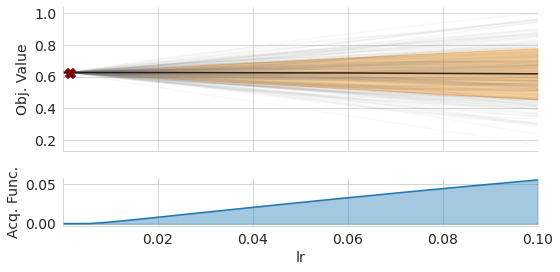

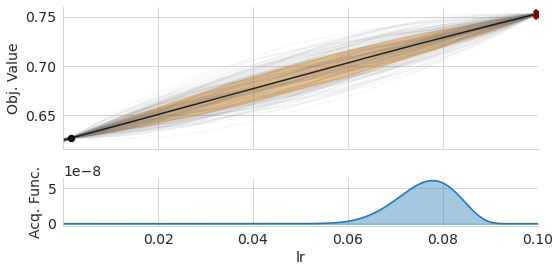

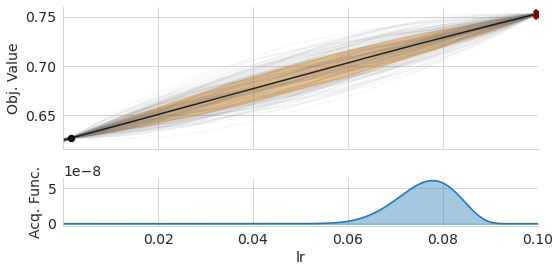

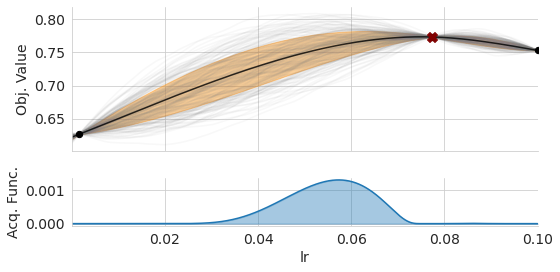

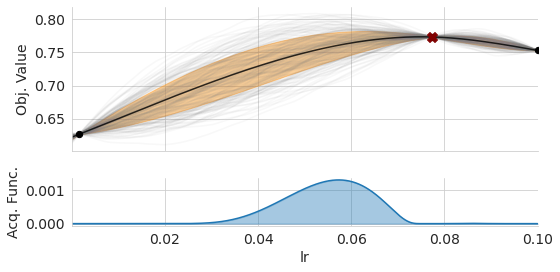

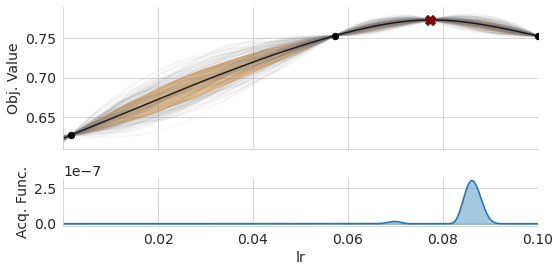

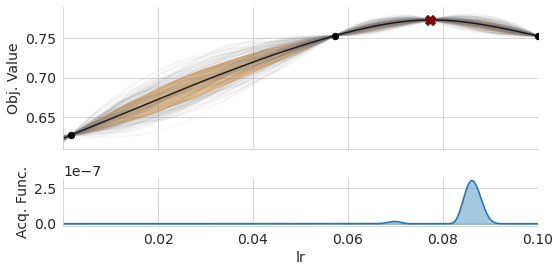

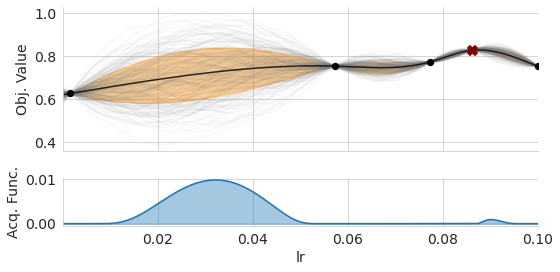

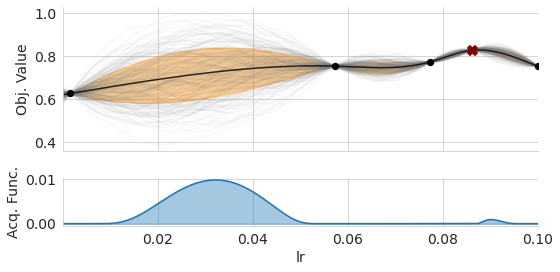

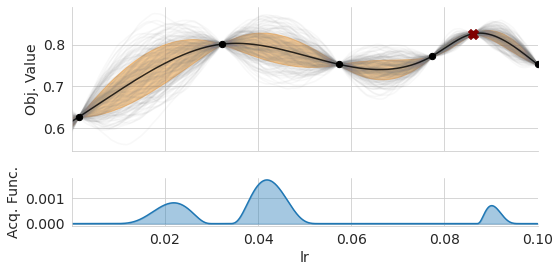

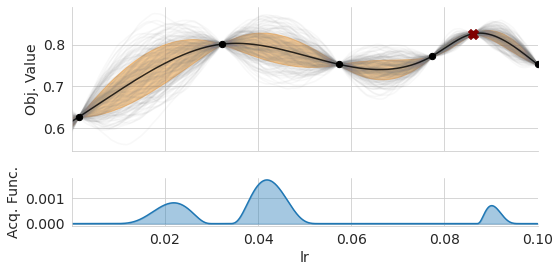

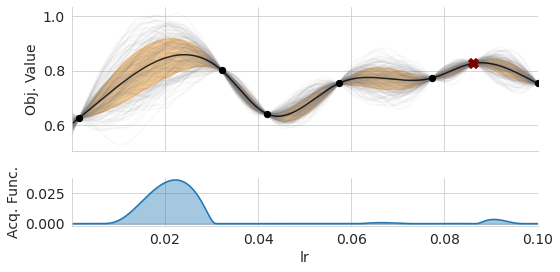

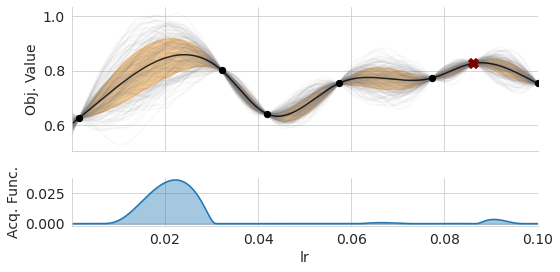

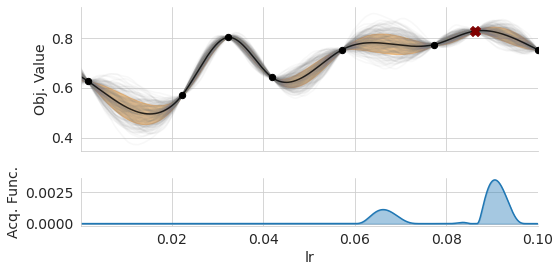

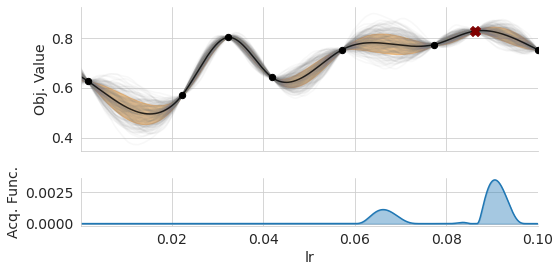

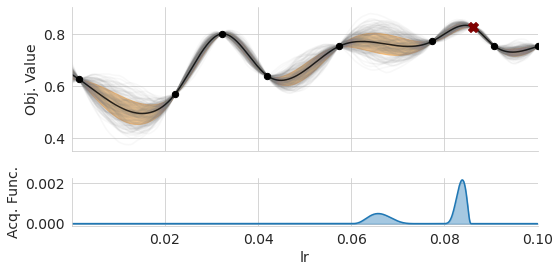

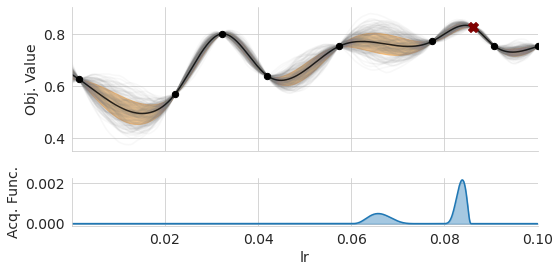

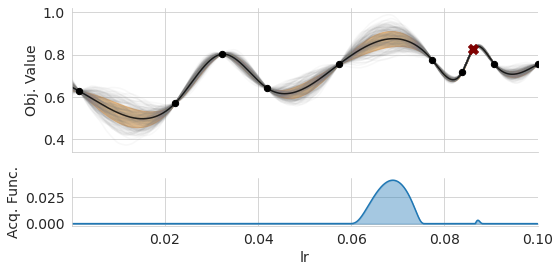

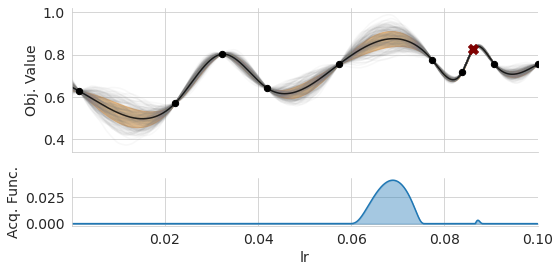

In [42]:
%matplotlib inline
import pylab as pyl
from IPython import display


bayesopt.optimize(1)

for idx in range(9):
    xopt, yopt = bayesopt.optimize(1)
    bayesopt.render()

    display.clear_output(wait=True)
    display.display(pyl.gcf())